<a href="https://colab.research.google.com/github/pantherer/NLP_task2/blob/main/NLP_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow Version: 2.19.0
✅ GPU is available. Training will be fast.

[STEP 1] Loading Data...
Successfully loaded twitter-2013train-A.txt (9684 rows)
Successfully loaded twitter-2015train-A.txt (489 rows)
Successfully loaded twitter-2016train-A.txt (6000 rows)
Successfully loaded twitter-2013test-A.txt (3547 rows)
Successfully loaded twitter-2015test-A.txt (2390 rows)
Successfully loaded twitter-2016test-A.txt (20633 rows)

Total Training samples: 16173
Total Test samples:     5937

[STEP 2] Preprocessing...
Classes detected: ['negative' 'neutral' 'positive']
Fitting Tokenizer on TRAIN data only...
Vocab Size: 24109
Train X shape: (16173, 100)
Test X shape:  (5937, 100)

[STEP 3] Building Model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,383,043 (5.28 MB)

 Trainable params: 1,383,043 (5.28 MB)

 Non-trainable params: 0 (0.00 B)


[STEP 4] Starting Training...
Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.4997 - loss: 0.9748 - val_accuracy: 0.5179 - val_loss: 0.9311
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7158 - loss: 0.6745 - val_accuracy: 0.4963 - val_loss: 1.0296
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8016 - loss: 0.4999 - val_accuracy: 0.5204 - val_loss: 1.0634
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8518 - loss: 0.3852 - val_accuracy: 0.5396 - val_loss: 1.2801
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8856 - loss: 0.3008 - val_accuracy: 0.5260 - val_loss: 1.4784
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9200 - loss: 0.2242 - val_accuracy: 0.5074 - val_loss: 1.8140
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9356 - loss: 0.1813 - val_accuracy: 0.5303 - val_loss: 2.0469
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 

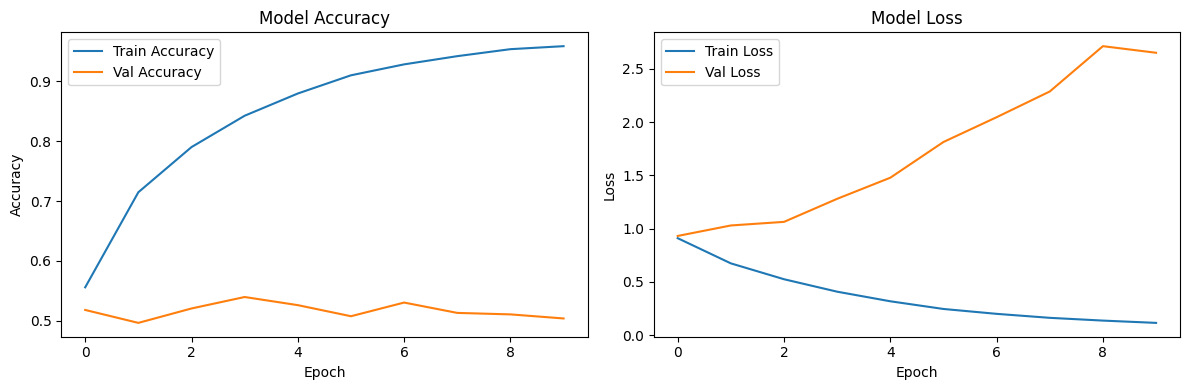

In [4]:
# ==========================================
# CELL 1: IMPORTS & SETUP
# ==========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Input

print("TensorFlow Version:", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available. Training will be fast.")
else:
    print("⚠️ GPU not found. Go to Runtime > Change runtime type > T4 GPU.")

# ==========================================
# CELL 2: DATA LOADING
# ==========================================

# Updated file lists based on your uploads
TRAIN_FILES = [
    "twitter-2013train-A.txt",
    "twitter-2015train-A.txt",
    "twitter-2016train-A.txt"
]

TEST_FILES = [
    "twitter-2013test-A.txt",
    "twitter-2015test-A.txt",
    "twitter-2016test-A.txt"
]

LABEL_MAP = {
    "positive": "positive",
    "negative": "negative",
    "neutral": "neutral",
    "objective-or-neutral": "neutral",
    "objective": "neutral" # Handling variations sometimes found in SemEval
}

def load_single_file(path):
    # Check if file exists
    if not os.path.exists(path):
        print(f"❌ Error: File not found '{path}'. Please check the file name.")
        return pd.DataFrame()

    try:
        # Parsing the TSV files (assuming tab separation)
        df = pd.read_csv(path, sep='\t', header=None, quoting=3, engine='python')

        # Logic to handle different column structures in SemEval datasets
        # Usually: ID, Sentiment, Text OR ID, Topic, Sentiment, Text
        if df.shape[1] == 3:
            df.columns = ["ID", "Sentiment", "Text"]
        elif df.shape[1] >= 4:
            # If 4 columns, usually index 2 is sentiment and 3 is text
            df = df.rename(columns={0: "ID", 2: "Sentiment", 3: "Text"})
            df = df[["ID", "Sentiment", "Text"]]

        print(f"Successfully loaded {path} ({len(df)} rows)")
        return df
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return pd.DataFrame()

def load_data(files):
    dfs = [load_single_file(f) for f in files]
    # Filter out empty dataframes
    dfs = [df for df in dfs if not df.empty]

    if not dfs:
        print("⚠️ No data loaded!")
        return pd.DataFrame(columns=["ID", "Sentiment", "Text"])

    df = pd.concat(dfs, ignore_index=True)

    # Standardize labels
    df['Sentiment'] = df['Sentiment'].str.strip().str.lower().map(LABEL_MAP)

    # Drop rows where text or label is missing
    return df.dropna(subset=['Sentiment', 'Text'])

print("\n[STEP 1] Loading Data...")
train_df = load_data(TRAIN_FILES)
test_df = load_data(TEST_FILES)

if train_df.empty or test_df.empty:
    raise ValueError("Data loading failed. Please check if files are uploaded to the correct directory.")

# Basic Text Cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "url", text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+', 'user', text)
    # Remove non-ascii chars usually helps with twitter data
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text

train_df['Clean_Text'] = train_df['Text'].apply(clean_text)
test_df['Clean_Text'] = test_df['Text'].apply(clean_text)

print(f"\nTotal Training samples: {len(train_df)}")
print(f"Total Test samples:     {len(test_df)}")

# ==========================================
# CELL 3: PREPROCESSING
# ==========================================
print("\n[STEP 2] Preprocessing...")

# 1. Encode Labels (Target)
le = LabelEncoder()
# Fit on ALL labels to ensure mapping is consistent
all_labels = pd.concat([train_df['Sentiment'], test_df['Sentiment']]).unique()
le.fit(all_labels)

y_train = le.transform(train_df['Sentiment'])
y_test = le.transform(test_df['Sentiment'])
num_classes = len(le.classes_)
print(f"Classes detected: {le.classes_}")

# 2. Tokenization (Input)
MAX_VOCAB_SIZE = 10000 # Maximum number of unique words to keep
MAX_LEN = 100          # Max length of a sentence

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")

# 🛑 CRITICAL: Fit ONLY on Training Data to prevent leakage
print("Fitting Tokenizer on TRAIN data only...")
tokenizer.fit_on_texts(train_df['Clean_Text'])

# Convert text to integers
X_train_seq = tokenizer.texts_to_sequences(train_df['Clean_Text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['Clean_Text'])

# 3. Padding (Ensure fixed input size)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Vocab Size: {len(tokenizer.word_index)}")
print(f"Train X shape: {X_train_pad.shape}")
print(f"Test X shape:  {X_test_pad.shape}")

# ==========================================
# CELL 4: BUILD BI-LSTM MODEL
# ==========================================
print("\n[STEP 3] Building Model...")

model = Sequential([
    Input(shape=(MAX_LEN,)),
    # Embedding Layer
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128),

    # Bi-LSTM Layer
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.3)),

    # Dense Layer
    Dense(32, activation='relu'),
    Dropout(0.3),

    # Output Layer
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy', # Use sparse since y is integers (0,1,2)
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# ==========================================
# CELL 5: TRAINING
# ==========================================
print("\n[STEP 4] Starting Training...")

history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# ==========================================
# CELL 6: EVALUATION & VISUALIZATION
# ==========================================
print("\n[STEP 5] Evaluating on Test Data...")

# Evaluate on the separated Test Files
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Final Test Accuracy: {acc*100:.2f}%")

# Predictions
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\n=== Classification Report (Bi-LSTM) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plotting Training History
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()